In [ ]:
#Importing all the Libraries

from numpy import asarray
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from PIL import Image
from io import BytesIO
from google.colab import files
import matplotlib.image as mpimg

In [ ]:
#Reading the image
image = cv.imread("lena.png",0)

image.shape

(512, 512)

In [ ]:
#Converting image from int to float
gray_img=image.astype('float32')

print(gray_img)
gray_img.shape

[[169. 169. 168. ... 175. 162. 138.]
 [169. 169. 168. ... 175. 162. 138.]
 [169. 169. 168. ... 175. 162. 138.]
 ...
 [ 53.  53.  59. ... 115. 112. 114.]
 [ 53.  53.  64. ... 117. 118. 122.]
 [ 53.  53.  64. ... 117. 118. 122.]]


(512, 512)

In [ ]:
#Normalizing the image

gray_img=gray_img/255.0
gray_img

array([[0.6627451 , 0.6627451 , 0.65882355, ..., 0.6862745 , 0.63529414,
        0.5411765 ],
       [0.6627451 , 0.6627451 , 0.65882355, ..., 0.6862745 , 0.63529414,
        0.5411765 ],
       [0.6627451 , 0.6627451 , 0.65882355, ..., 0.6862745 , 0.63529414,
        0.5411765 ],
       ...,
       [0.20784314, 0.20784314, 0.23137255, ..., 0.4509804 , 0.4392157 ,
        0.44705883],
       [0.20784314, 0.20784314, 0.2509804 , ..., 0.45882353, 0.4627451 ,
        0.47843137],
       [0.20784314, 0.20784314, 0.2509804 , ..., 0.45882353, 0.4627451 ,
        0.47843137]], dtype=float32)

In [ ]:
#Max and Min Values after normalizing
print('Min: %.3f,Max: %.3f'%(gray_img.min(),gray_img.max()))

Min: 0.153,Max: 0.961


(512, 512)

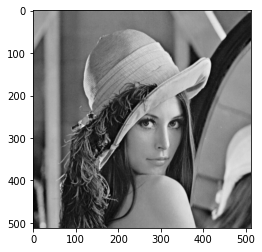

In [ ]:
#Plotting the Normalized imgae
plt.imshow(gray_img,cmap='gray')
gray_img.shape

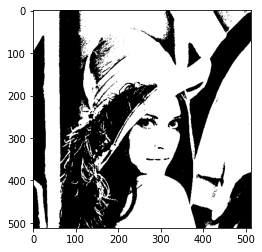

In [ ]:
#Converting to Binary Image
_,BG=cv.threshold(gray_img,0.5,1,cv.THRESH_BINARY)
plt.imshow(BG,cmap='gray')

In [ ]:
#Calculating the moments

import math
#img = cv.imread('binary.png')
#img=cv.cvtColor(img,cv.COLOR_BGR2GRAY)

# Calculate Moments
m = cv.moments(BG)

In [ ]:
# calculate x,y coordinate of center using the moments
cX = int(m["m10"] / m["m00"])
cY = int(m["m01"] / m["m00"])

print(cX,cY)

281 234


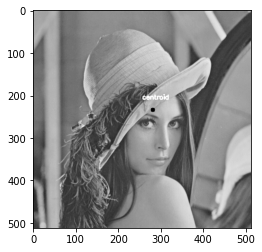

In [ ]:
#PIN-POINTING THE CENTROID OF THE IMAGE

cv.circle(gray_img, (cX, cY), 5, (0,0,0), -1)
cv.putText(gray_img, "centroid", (cX - 25, cY - 25),cv.FONT_HERSHEY_SIMPLEX, 0.5, (1, 1, 1), 2)
plt.imshow(gray_img,cmap="gray")

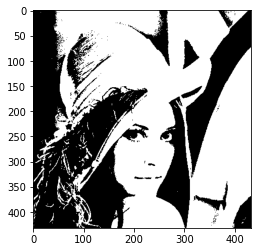

In [ ]:
#Extracting the Effective region using the centroid as a reference point

import numpy as np
from PIL import Image, ImageDraw
originalImage = BG
slicedImage = originalImage[cY-216:cY+216, cX-216:cX+216]

plt.imshow(slicedImage,cmap='gray')


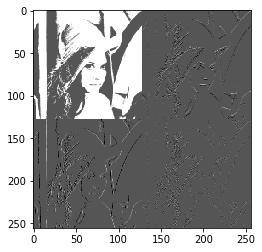

In [ ]:

import pywt


#APPLYING 2 LEVELS OF DWT

npImage=BG
#LEVEL 1
data = np.array(npImage, dtype=np.float64)
coeffs1 = pywt.dwt2(data, 'haar')
LL1, (LH1, HL1, HH1) = coeffs1


#LEVEL 2
coeffs2 = pywt.dwt2(LL1, 'haar')
LL2, (LH2, HL2, HH2) = coeffs2


#Copying LL2 into LL3
LL3=LL2
HL3=HL2
LH3=LH2
HH3=HH2

#CONCATENATING DIFFERENT BANDS FOR PLOTTING TOGETHER
AH = np.concatenate([LL2, LH2], axis=1)
VD = np.concatenate([HL2, HH2], axis=1)
img0 = np.concatenate([AH, VD], axis=0)
plt.imshow(img0,cmap='gray',interpolation='nearest')

In [ ]:
#SHAPE OF THE LL2 BAND OBTAINED
LL2.shape

(128, 128)

In [ ]:
#SPLITTING THE IMAGE OF 128X128 INTO A MATRIX OF 16X16 TILES
arr = np.asarray(LL2)
arr = np.split(arr, 16)
arr = np.array([np.split(x, 16, 1) for x in arr])

In [ ]:
#SHAPE OF THE MATRIX 
arr.shape

(16, 16, 8, 8)

In [ ]:
#CONVERTING THE MATRIX OF TILES INTO A LIST TO COMPUTE SVD

arr1=[]
for z1 in range(16):
  for z2 in range(16):
    arr1.append(arr[z1][z2])

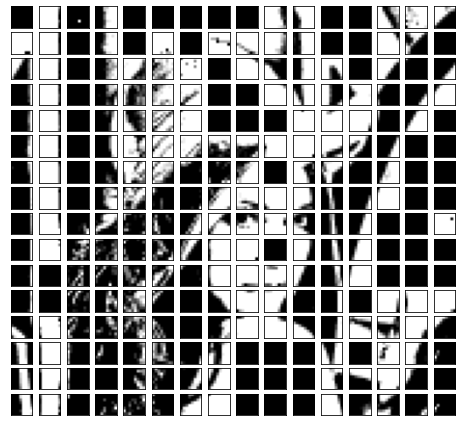

In [ ]:
#Plotting the tiles

n = 16  
plt.figure(figsize=(8, 8))
for i in range(256):
    # Display reconstruction
    ax = plt.subplot(n+1, n, i + n + 1)
    plt.imshow(arr1[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [ ]:
from scipy.linalg import svd


#APPLYING THE SVD

U=[0 for x in range(256)]
S=[0 for x in range(256)]
VT=[0 for x in range(256)]
for x1 in range(256):
  U[x1],S[x1],VT[x1]=svd(arr1[x1])


In [ ]:
#EXTRACTING THE MAX VALUES FROM THE S[] MATRIX OF EACH TILE INTO A NEW LIST

S1=[]
for z1 in range(256):
  S1.append(max(S[z1]))

In [ ]:
#THE MAX SINGULAR VALUE ACCUMULATED TOGETHER FORMS UP THE FEATURE IMAGE

image=np.array(S1)
image=image.reshape(16,16)

plt.imshow(image)


In [ ]:
from PIL import Image
from io import BytesIO
from google.colab import files
from google.colab.patches import cv2_imshow
import cv2


#Function to crop the image
def crop_square(img, size, interpolation=cv2.INTER_AREA):
    h, w = img.shape[:2]
    min_size = np.amin([h,w])
    # Centralize and crop
    crop_img = img[int(h/2-min_size/2):int(h/2+min_size/2), int(w/2-min_size/2):int(w/2+min_size/2)]
    resized = cv2.resize(crop_img, (size, size), interpolation=interpolation)

    return resized


#Function to scramble image
def catmap(frame,n):
  s=frame.shape
  pic= np.zeros(s,np.uint8)
  A=np.array([[2,1],[1,1]])
  ind=A@np.indices(s).reshape(2,-1)%(np.array(s)[:,None])
  pic[ind[0],ind[1]]=frame.reshape(-1)

  return pic


cv2.destroyAllWindows()

True

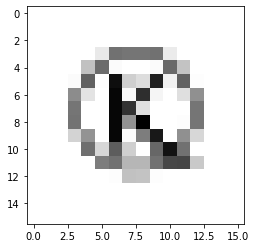

In [ ]:
#LOADING THE WATERMARK(LOGO) AND CONVERTING IT TO SIZE OF 16x16 

watermark=cv.imread("logo.png",0)
watermark=crop_square(watermark,16)
plt.imshow(watermark,cmap='gray')

cv.imwrite('logo1.png',watermark)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  import sys


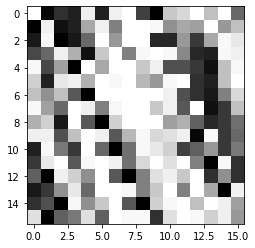

In [ ]:
#SCRAMBLING THE FEATURE IMAGE
scrambled_image=catmap(image,100)


si=scrambled_image
si = 255.0 * (si - si.min()) / (si.max() - si.min())
si = np.array(si, np.int)
cv.imwrite('scrambled_image.png',si)
plt.imshow(scrambled_image,cmap='gray')


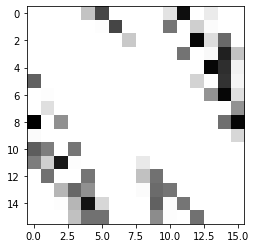

In [ ]:
#Scrambling Watermark Image

scrambled_watermark=catmap(watermark,100)
plt.imshow(scrambled_watermark,cmap='gray')
plt.show()

In [ ]:
#NORMALIZING THE SCRAMBLED WATERMARK IMAGE
scrambled_watermark1=scrambled_watermark
scrambled_watermark=scrambled_watermark1/255

In [ ]:
#NORMALIZING THE SCRAMBLED FEATURE IMAGE
np.amax(scrambled_image)
scrambled_image=scrambled_image/32

In [ ]:
#LINEAR COMBINATION OF SCRAMBLED FEATURE IMAGE AND SCRAMBLED WATERMARK TO GET ZERO-WATERMARK


zero_watermark=0.2*scrambled_image + 0.8*scrambled_watermark

#zero_watermark=np.bitwise_xor(np.uint64(scrambled_watermark), np.uint64(scrambled_image))

In [ ]:
#NORMALIZING THE ZERO-WATERMARK 
zero_watermark=zero_watermark/255

In [ ]:
#SAVING THE ZERO-WATERMARK

zw=zero_watermark
zw = 255 * (zw - zw.min()) / (zw.max() - zw.min())
zw = np.array(zw, np.int)
cv.imwrite('zero_watermark.png',zw)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


True

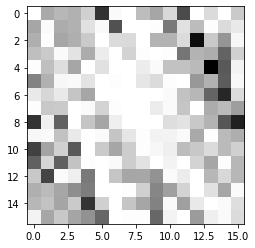

In [ ]:
#PLOTTING THE ZERO-WATERMARK

plt.imshow(zero_watermark,cmap='gray')

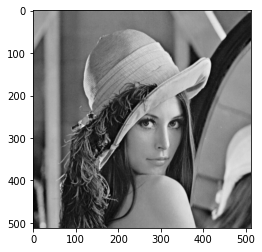

In [ ]:
#LOADING THE ORIGINAL IMAGE TO EMBED ZERO-WATERMARK INTO IT

image1=cv.imread('lena.png',0)
plt.imshow(image1,cmap='gray')

In [ ]:
#CONVERTING THE ORIGINAL IMAGE INTO A MATRIX OF 32X32,EACH ELEMENT IN THAT OF 16X16

arr11 = np.asarray(image1)
arr11 = np.split(arr11, 32)
arr11 = np.array([np.split(x, 32, 1) for x in arr11])

In [ ]:
#XOR-ING THE IMAGE MATRIX AND ZERO-WATERMARK TO EACH 16X16 IN THE 32X32 MATRIX
arr22=arr11.astype('float32')
for z1 in range(len(arr11)):
  arr11[z1]=np.bitwise_xor(np.uint64(arr22[z1]),np.uint64(zero_watermark))
  

In [ ]:
#CONCATENATING THE IMAGE MATRIX INTO THE SIZE OF 32X16=512X512
arr11 = np.array([np.concatenate([np.concatenate(x,1) for x in arr11])])
arr11 = np.expand_dims(arr11, axis=-3)
print(arr11.shape)

(1, 1, 512, 512)


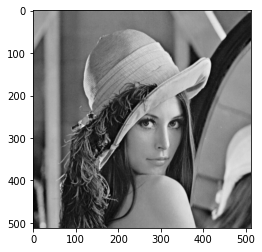

In [ ]:
final=arr11[0][0]

#Saving and plotting the watermarked image
cv.imwrite('watermarked_image.png',final)
plt.imshow(final,cmap='gray')

In [ ]:
from skimage.metrics import structural_similarity as ssim

#Comparing the Watermarked image and the original image
comparison_value=ssim(final,image1)
print('The Similarity value is %0.2f'%comparison_value)

The Similarity value is 1.00
